In [166]:
import numpy as np
import json
import re
from nltk.stem import WordNetLemmatizer
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.initializers import Constant
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM,Embedding,Dense,Flatten,Input
import matplotlib.pyplot as plt
import random

In [120]:
with open('dataset.json',errors='ignore') as content:
    data=json.load(content)

In [121]:
intents=[]
inputs=[]
responses={}
for intent in data['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
        inputs.append(lines)
        intents.append(intent['intent'])

In [122]:
intents[:10]

['greeting1',
 'greeting1',
 'greeting2',
 'greeting2',
 'greeting2',
 'greeting2',
 'greeting3',
 'greeting4',
 'greeting5',
 'greeting6']

In [123]:
inputs[:10]

['hi, how are you doing',
 'how are you doing',
 "i'm pretty good. thanks for asking",
 "I'm pretty good, thanks",
 'Good',
 'great',
 'How do you do?',
 'Hi, nice to meet you',
 "What's up?",
 'Hello']

In [124]:
responses['greeting1']

["i'm fine. how about yourself",
 "i'm pretty good. thanks for asking",
 'Good',
 'Very well, thanks',
 'Fine, and you',
 'Thank you',
 "I'm doing well",
 "I'm doing OK. Looking forwards to the weekend. how about you?"]

In [125]:
inputs[0]

'hi, how are you doing'

In [126]:
intents[0]

'greeting1'

In [127]:
responses['greeting1']

["i'm fine. how about yourself",
 "i'm pretty good. thanks for asking",
 'Good',
 'Very well, thanks',
 'Fine, and you',
 'Thank you',
 "I'm doing well",
 "I'm doing OK. Looking forwards to the weekend. how about you?"]

In [128]:
len(inputs)

242

In [129]:
len(intents)

242

In [130]:
lemmatizer=WordNetLemmatizer()

In [131]:
def preprocessing(text):
    text=text.lower()
    text=re.sub('[^a-z]',' ',text)
    text=re.sub('\s+[a-z]\s+',' ',text)
    text=re.sub('\s+',' ',text)
    words=text.split()
    words=[lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [132]:
df=pd.DataFrame()
df['inputs']=inputs
df['intents']=intents

In [133]:
df

,inputs,intents
0,"hi, how are you doing",greeting1
1,how are you doing,greeting1
2,i'm pretty good. thanks for asking,greeting2
3,"I'm pretty good, thanks",greeting2
4,Good,greeting2
...,...,...
237,what is ds,talk73
238,ds,talk73
239,explain data science,talk73
240,what is the role of government in education?,talk74


In [134]:
df['preprocessed_input']=df['inputs'].apply(preprocessing)

In [135]:
df

,inputs,intents,preprocessed_input
0,"hi, how are you doing",greeting1,hi how are you doing
1,how are you doing,greeting1,how are you doing
2,i'm pretty good. thanks for asking,greeting2,i pretty good thanks for asking
3,"I'm pretty good, thanks",greeting2,i pretty good thanks
4,Good,greeting2,good
...,...,...,...
237,what is ds,talk73,what is d
238,ds,talk73,d
239,explain data science,talk73,explain data science
240,what is the role of government in education?,talk74,what is the role of government in education


In [136]:
df.isnull().sum()

inputs                0
intents               0
preprocessed_input    0
dtype: int64

In [137]:
df.drop(columns=['inputs'],axis=1,inplace=True)

In [138]:
df.head()

,intents,preprocessed_input
0,greeting1,hi how are you doing
1,greeting1,how are you doing
2,greeting2,i pretty good thanks for asking
3,greeting2,i pretty good thanks
4,greeting2,good


In [139]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df['preprocessed_input'])
sequences=tokenizer.texts_to_sequences(df['preprocessed_input'])

In [140]:
sequences[:10]

[[31, 7, 6, 2, 90],
 [7, 6, 2, 90],
 [14, 65, 32, 66, 29, 141],
 [14, 65, 32, 66],
 [32],
 [49],
 [7, 5, 2, 5],
 [31, 40, 17, 67, 2],
 [1, 142],
 [68]]

In [141]:
maxlen=max([len(i) for i in sequences])

In [142]:
maxlen

15

In [143]:
padded_sequences=pad_sequences(sequences,maxlen=maxlen,padding='pre')

In [144]:
padded_sequences

array([[  0,   0,   0, ...,   6,   2,  90],
       [  0,   0,   0, ...,   6,   2,  90],
       [  0,   0,   0, ...,  66,  29, 141],
       ...,
       [  0,   0,   0, ...,  16,  63,  64],
       [  0,   0,   0, ...,  79,   8,  83],
       [  0,   0,   0, ...,  45,   8,  83]])

In [145]:
vocab_size=len(tokenizer.word_index)+1

In [146]:
vocab_size

280

In [147]:
le=LabelEncoder()
y=le.fit_transform(df['intents'])

In [148]:
X=padded_sequences

In [149]:
len(X)

242

In [150]:
len(y)

242

In [151]:
embedding_dictionary=dict()
glove_file=open('glove.6B.100d.txt',encoding='utf8')
for line in glove_file:
    records=line.split()
    word=records[0]
    vector_dimensions=np.asarray(records[1:],dtype='float32')
    embedding_dictionary[word]=vector_dimensions
glove_file.close()

In [152]:
embedding_dictionary['good']

array([-0.030769 ,  0.11993  ,  0.53909  , -0.43696  , -0.73937  ,
       -0.15345  ,  0.081126 , -0.38559  , -0.68797  , -0.41632  ,
       -0.13183  , -0.24922  ,  0.441    ,  0.085919 ,  0.20871  ,
       -0.063582 ,  0.062228 , -0.051234 , -0.13398  ,  1.1418   ,
        0.036526 ,  0.49029  , -0.24567  , -0.412    ,  0.12349  ,
        0.41336  , -0.48397  , -0.54243  , -0.27787  , -0.26015  ,
       -0.38485  ,  0.78656  ,  0.1023   , -0.20712  ,  0.40751  ,
        0.32026  , -0.51052  ,  0.48362  , -0.0099498, -0.38685  ,
        0.034975 , -0.167    ,  0.4237   , -0.54164  , -0.30323  ,
       -0.36983  ,  0.082836 , -0.52538  , -0.064531 , -1.398    ,
       -0.14873  , -0.35327  , -0.1118   ,  1.0912   ,  0.095864 ,
       -2.8129   ,  0.45238  ,  0.46213  ,  1.6012   , -0.20837  ,
       -0.27377  ,  0.71197  , -1.0754   , -0.046974 ,  0.67479  ,
       -0.065839 ,  0.75824  ,  0.39405  ,  0.15507  , -0.64719  ,
        0.32796  , -0.031748 ,  0.52899  , -0.43886  ,  0.6740

In [153]:
embedding_matrix=np.zeros((vocab_size,100))
for word,index in tokenizer.word_index.items():
    embedding_vector=embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector

In [154]:
embedding_matrix[1]

array([-1.51800007e-01,  3.84090006e-01,  8.93400013e-01, -4.24210012e-01,
       -9.21609998e-01,  3.79879996e-02, -3.20259988e-01,  3.41190002e-03,
        2.21010000e-01, -2.20449999e-01,  1.66610003e-01,  2.19559997e-01,
        2.53250003e-01, -2.92670012e-01,  1.01709999e-01, -7.54910037e-02,
       -6.04059994e-02,  2.81940013e-01, -5.85189998e-01,  4.82710004e-01,
        1.75039992e-02, -1.20860003e-01, -1.09899998e-01, -6.95540011e-01,
        1.56000003e-01,  7.05579966e-02, -1.50580004e-01, -8.18109989e-01,
       -1.85350001e-01, -3.68629992e-01,  3.16499993e-02,  7.66160011e-01,
        8.40409994e-02,  2.69280002e-03, -2.74399996e-01,  2.18150005e-01,
       -3.51569988e-02,  3.25690001e-01,  1.00319996e-01, -6.09319985e-01,
       -7.03159988e-01,  1.82990000e-01,  3.31339985e-01, -1.24159999e-01,
       -9.05420005e-01, -3.91569994e-02,  4.47189987e-01, -5.73379993e-01,
       -4.01719987e-01, -8.22340012e-01,  5.57399988e-01,  1.51010007e-01,
        2.45979995e-01,  

In [155]:
num_classes=df['intents'].nunique()
num_classes

108

In [159]:
i=Input(shape=(maxlen,))
x=Embedding(vocab_size,100,embeddings_initializer=Constant(embedding_matrix),trainable=False)(i)
x=LSTM(10,return_sequences=True)(x)
x=Flatten()(x)
x=Dense(num_classes,activation='softmax')(x)
model=Model(i,x)

In [160]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [161]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 15, 100)             │          28,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 15, 10)              │           4,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 108)                 │          16,308 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,748 (190.42 KB)

 Trainable params: 48,748 (190.42 KB)

 Non-trainable params: 0 (0.00 B)

In [162]:
history=model.fit(X,y,epochs=150)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0146 - loss: 4.6887
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0465 - loss: 4.6027
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0754 - loss: 4.4761
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1265 - loss: 4.3155
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1148 - loss: 4.1492
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0927 - loss: 4.1161
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1139 - loss: 3.9743 
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1189 - loss: 3.9820 
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1009 - loss: 3.9262 
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1554 - loss: 3.7979
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1204 - loss: 3.8043 
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1707 - loss: 3.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9085 - loss: 0.7544
Epoch 71/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8872 - loss: 0.7415
Epoch 72/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9153 - loss: 0.7374
Epoch 73/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9210 - loss: 0.7297
Epoch 74/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9048 - loss: 0.7378 
Epoch 75/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9144 - loss: 0.6683
Epoch 76/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9389 - loss: 0.6651
Epoch 77/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8985 - loss: 0.7135
Epoch 78/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9240 - loss: 0.6817
Epoch 79/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9233 - loss: 0.6250
Epoch 80/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9413 - loss: 0.6349
Epoch 81/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9536 - loss: 0.61

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9572 - loss: 0.2893
Epoch 139/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9383 - loss: 0.2771
Epoch 140/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9478 - loss: 0.2785 
Epoch 141/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9367 - loss: 0.2914
Epoch 142/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9452 - loss: 0.2822
Epoch 143/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9340 - loss: 0.2964 
Epoch 144/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9103 - loss: 0.2937
Epoch 145/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9334 - loss: 0.2874
Epoch 146/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9623 - loss: 0.2593
Epoch 147/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9597 - loss: 0.2732
Epoch 148/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9474 - loss: 0.2622
Epoch 149/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9506 - 

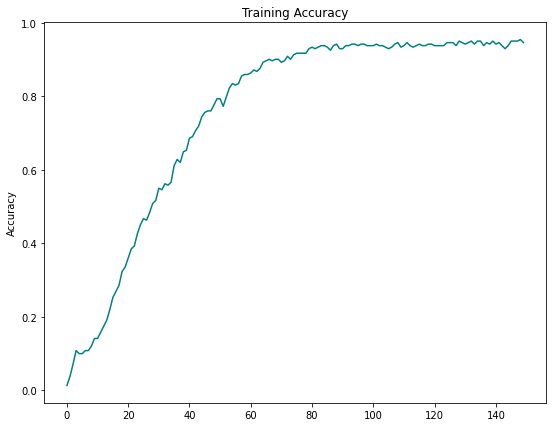

In [164]:
plt.figure(figsize=(9,7))
plt.plot(history.history['accuracy'],color='teal')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.show()

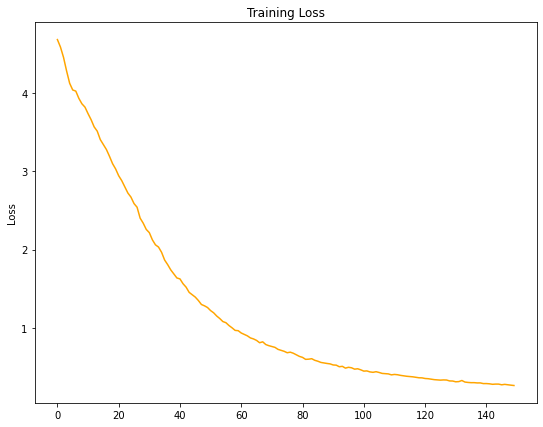

In [165]:
plt.figure(figsize=(9,7))
plt.plot(history.history['loss'],color='orange')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.show()

In [178]:
while True:
    text_p=[]
    prediction_input=input('You: ')
    prediction_input=preprocessing(prediction_input)
    text_p.append(prediction_input)
    prediction_input=tokenizer.texts_to_sequences(text_p)
    prediction_input=np.array(prediction_input).reshape(-1)
    prediction_input=pad_sequences([prediction_input],maxlen=maxlen,padding='pre')
    output=model.predict(prediction_input)
    output=output.argmax()
    response_tag=le.inverse_transform([output])[0]
    print('AliTech: ',random.choice(responses[response_tag]))
    if response_tag=='goodbye':
        break

You: hi, how are you doing?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AliTech:  I'm doing OK. Looking forwards to the weekend. how about you?
You: whats'up?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
AliTech:  No worries!
You: do you eat?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
AliTech:  I'm a computer, I can't eat or drink
You: tell me a joke
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
AliTech:  How does Darth Vader like his toast? On the Dark Side.
You: what language are you written it?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
AliTech:  I am written in Python
You: what is the name of the nearest major galaxy to the milky way?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
AliTech:  The Andromeda Galaxy
You: do you know me?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
AliTech:  Yes, you are a human
You: what is ai?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
AliTech:  AI is the field of science which concerns itself with building hardware and software that replicates the functions of the human mind.
You: what is your fear?
1/